# NDVI Analysis for Agricultural Crop Health Monitoring

**Project**: Precision Agriculture – Vegetation Health Assessment  
**Application**: Avocado Grove Water Quality Management  
**Data Source**: DroneMapper Multispectral Imagery (MicaSense Altum)  
&nbsp;&nbsp;URL: https://dronemapper.com/software/DroneMapper_CropAnalysis_Data.zip  
**Created**: February 2026  
**Imagery © DroneMapper; used here for educational and demonstration purposes.**
---

## What is NDVI?

**NDVI (Normalized Difference Vegetation Index)** is a numerical indicator that measures the health and vigor of vegetation using remote sensing data.

**Formula**: NDVI = (NIR - Red) / (NIR + Red)

**How it works**:
- Healthy plants **absorb** red light (for photosynthesis)
- Healthy plants **reflect** near-infrared (NIR) light
- Higher NDVI values = healthier vegetation

**NDVI Values**:
- **0.8 to 1.0**: Very dense, healthy vegetation
- **0.6 to 0.8**: Healthy crops with good coverage
- **0.4 to 0.6**: Moderate vegetation or stressed crops
- **0.2 to 0.4**: Sparse vegetation
- **-1 to 0.2**: Bare soil, water, or severely stressed plants

---

## Applications for Agricultural Water Quality

In its current form, this NDVI workflow demonstrates how to:

1. **Generate NDVI maps from high‑resolution drone imagery** over a plot 
2. **Visualize spatial patterns in canopy vigor** that could be related to chloride stress  
3. **Produce presentation‑ready figures** that can support evaluation of chloride‑removal strategies  

With the additional steps outlined in the “Next Steps for this Project” section
(clipping control vs treatment plots and building a time‑series dataset), the
same workflow can then be used to:

- Evaluate avocado tree health under high‑chloride vs treated irrigation water  
- Validate chloride‑removal system performance over the 2026 growing season  
- Quantify NDVI‑based changes in canopy vigor that may translate into yield and quality differences  


---

## Dataset Information

**Sensor**: MicaSense Altum (multispectral + thermal camera)  
**Resolution**: ~5-8 cm per pixel (high resolution!)  
**Coverage**: ~2-5 acre agricultural field  
**Bands**: Red, Green, Blue, Near-Infrared (NIR), RedEdge, Thermal  
**Date**: Single time point (October 2019)

**Pre‑processing**:  
The imagery used in this notebook is a pre‑processed, georeferenced
multispectral orthomosaic (GeoTIFF). The stitching, camera calibration,
and georeferencing were performed in external photogrammetry software
before analysis.  

The future avocado trial will follow similar steps: weekly drone flights
(e.g., DJI P4 Multispectral) will be processed with vendor or third‑party
mapping software to produce georeferenced multispectral GeoTIFFs, which
can then be analyzed with this NDVI workflow.



---

## Notebook Structure

This notebook is organized into these sections:
1. **Setup** - Install packages and import libraries
2. **Data Loading** - Read multispectral imagery
3. **NDVI Calculation** - Compute vegetation index
4. **Classification** - Categorize vegetation health
5. **Visualization** - Create presentation-ready maps
6. **Export** - Save results for reports/presentations

**Estimated runtime**: 2-3 minutes

---

## 1. Setup: Install Required Packages

**Run this cell ONCE** when you first open the notebook. It installs all the Python libraries we need.

**What each package does**:
- `rasterio`: Opens and reads geospatial raster files (like satellite/drone imagery)
- `earthpy`: Simplifies remote sensing calculations and plotting
- `geopandas`: Handles geographic vector data (field boundaries, polygons)
- `rasterstats`: Calculates statistics for specific geographic zones

**Note**: If packages are already installed, you'll see "Requirement already satisfied" - that's fine!

In [1]:
# Install required packages (only needs to run once)
import sys
!{sys.executable} -m pip install rasterio earthpy geopandas rasterstats --quiet

print("✓ Package installation complete!")
print("\nIf you see any RED error messages above, that's usually okay.")


✓ Package installation complete!

If you see any RED error messages above, that's usually okay.


## 2. Import Libraries and Configure Settings

This cell loads all the Python libraries we need for the analysis.

**Key libraries**:
- `numpy`: Mathematical operations on arrays
- `rasterio`: Reading geospatial image files
- `matplotlib`: Creating plots and visualizations
- `earthpy`: Remote sensing specific functions

We also configure some settings to:
- Suppress warning messages (makes output cleaner)
- Create an output folder for our results

In [2]:
# Import all required libraries
import numpy as np                    # Math operations on arrays
import rasterio                       # Read geospatial raster data
from matplotlib import pyplot as plt  # Create plots
import matplotlib as mpl              # Additional plotting settings
import earthpy as et                  # Earth science data tools
import earthpy.plot as ep             # Plotting functions for remote sensing
import earthpy.spatial as es          # Spatial analysis functions
import os                             # File and folder operations

# Optional libraries (will work without these if not installed)
try:
    import geopandas as gpd           # Geographic vector data
    from rasterio.plot import plotting_extent
    import rasterstats as rs          # Zonal statistics
    ADVANCED_FEATURES = True
except ImportError:
    ADVANCED_FEATURES = False
    print("Note: Some advanced features disabled (geopandas/rasterstats not found)")
    print("Core NDVI analysis will still work perfectly!\n")

# Configure settings for cleaner output
np.seterr(divide='ignore', invalid='ignore')  # Suppress divide-by-zero warnings
import warnings
warnings.filterwarnings('ignore')  # Suppress other warnings

# Create output folder for saving results
os.makedirs('output', exist_ok=True)  # exist_ok=True means "don't error if folder exists"

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.dpi'] = 100       # Screen display quality
plt.rcParams['savefig.dpi'] = 300      # Saved image quality (high res)
plt.rcParams['font.size'] = 10         # Default font size

print("="*60)
print("✓ All libraries loaded successfully!")
print("="*60)
print(f"\n📁 Working directory: {os.getcwd()}")
print(f"📁 Output folder created: {os.path.abspath('output')}")
print(f"\nAdvanced features (plot analysis): {'Enabled' if ADVANCED_FEATURES else 'Disabled'}")

C:\Users\Greg\anaconda3\Lib\site-packages\earthpy\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


✓ All libraries loaded successfully!

📁 Working directory: C:\Users\Greg\Desktop\Greg\learning_ideas\Water_Projects\TailWater\DroneMapper_CropAnalysis_Data
📁 Output folder created: C:\Users\Greg\Desktop\Greg\learning_ideas\Water_Projects\TailWater\DroneMapper_CropAnalysis_Data\output

Advanced features (plot analysis): Enabled


## 3. Verify Data Files

Before we start the analysis, let's make sure all the required data files are in the right place.

**Expected files**:
- `DrnMppr-ORT-AOI.tif` - Multispectral orthomosaic (main file)
- `DrnMppr-DEM-AOI.tif` - Digital elevation model (optional but nice)

**📝 EDIT THIS CELL**: If your data is in a different folder, change the `data_folder` path below.

In [3]:
# ========================================
# EDIT THIS: Set your data folder path
# ========================================

data_folder = r"C:\Users\Greg\Desktop\Greg\learning_ideas\Water_Projects\TailWater\DroneMapper_CropAnalysis_Data"


# If your data is somewhere else, uncomment and edit one of these examples:
# data_folder = 'data'  # If you moved files to a 'data' subfolder
# data_folder = '../DroneMapper_CropAnalysis_Data'  # If data is one folder up
# data_folder = 'C:/Users/YourName/Desktop/DroneMapper_CropAnalysis_Data'  # Full path (Windows)
# data_folder = '/Users/YourName/Desktop/DroneMapper_CropAnalysis_Data'  # Full path (Mac)

# ========================================
# File verification (don't edit below here)
# ========================================

# Define the files we need
required_files = {
    'orthomosaic': os.path.join(data_folder, 'DrnMppr-ORT-AOI.tif'),
    'dem': os.path.join(data_folder, 'DrnMppr-DEM-AOI.tif'),
}

print("Checking for data files...\n")
print("="*60)

files_found = {}
for name, filepath in required_files.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)  # Convert bytes to megabytes
        print(f"✓ Found {name}: {filepath}")
        print(f"  Size: {size_mb:.1f} MB")
        files_found[name] = True
    else:
        print(f"✗ MISSING {name}: {filepath}")
        print(f"  → Check that the file exists and the path is correct")
        files_found[name] = False
    print()

# Summary
print("="*60)
if files_found['orthomosaic']:
    print("✓ SUCCESS! All required files found.")
    print("\nYou're ready to proceed to the next cell!")
else:
    print("⚠️  MISSING FILES!")
    print("\nTroubleshooting:")
    print("1. Check that you've unzipped the DroneMapper data")
    print("2. Make sure the data folder path above is correct")
    print("3. Check that the .tif files are in that folder")
    print("\nCurrent folder contents:")
    if os.path.exists(data_folder):
        files_in_folder = os.listdir(data_folder)
        for f in files_in_folder:
            print(f"  - {f}")
    else:
        print(f"  Folder '{data_folder}' does not exist!")

Checking for data files...

✓ Found orthomosaic: C:\Users\Greg\Desktop\Greg\learning_ideas\Water_Projects\TailWater\DroneMapper_CropAnalysis_Data\DrnMppr-ORT-AOI.tif
  Size: 119.6 MB

✓ Found dem: C:\Users\Greg\Desktop\Greg\learning_ideas\Water_Projects\TailWater\DroneMapper_CropAnalysis_Data\DrnMppr-DEM-AOI.tif
  Size: 17.1 MB

✓ SUCCESS! All required files found.

You're ready to proceed to the next cell!


## 4. Load Multispectral Imagery

Now we'll load the drone imagery into Python.

**What's happening**:
1. Open the orthomosaic file (contains all 6 spectral bands)
2. Read it as a 3D array: `(bands, rows, columns)`
3. Load the elevation model for context

**Band order in the orthomosaic**:
- Band 0 = Red
- Band 1 = Green
- Band 2 = Blue
- Band 3 = Near-Infrared (NIR) ← We need this for NDVI
- Band 4 = RedEdge
- Band 5 = Thermal

**For NDVI, we only need**: Band 0 (Red) and Band 3 (NIR)

In [4]:
print("="*60)
print("LOADING MULTISPECTRAL DRONE IMAGERY")
print("="*60)

# Load the multispectral orthomosaic
print("\n[1/2] Loading orthomosaic (all spectral bands)...")
ortho = rasterio.open(required_files['orthomosaic'])  # Open the file
ortho_arr = ortho.read()  # Read all bands into a numpy array
# ortho_arr is now a 3D array with shape (bands, height, width)

print(f"✓ Orthomosaic loaded successfully")
print(f"  Shape: {ortho_arr.shape[0]} bands × {ortho_arr.shape[1]} rows × {ortho_arr.shape[2]} columns")
print(f"  Total pixels per band: {ortho_arr.shape[1] * ortho_arr.shape[2]:,}")
print(f"  Data type: {ortho_arr.dtype}")

# Load the digital elevation model (DEM)
print("\n[2/2] Loading elevation model...")
if files_found['dem']:
    dem = rasterio.open(required_files['dem'])  # Open the DEM file
    dem_arr = dem.read()  # Read into array
    elevation = dem_arr[0]  # DEM only has 1 band, get it
    elevation[elevation <= 0] = np.nan  # Set invalid elevations to NaN (Not a Number)
    print(f"✓ Elevation model loaded")
    print(f"  Shape: {elevation.shape}")
    print(f"  Elevation range: {np.nanmin(elevation):.1f} to {np.nanmax(elevation):.1f} meters")
else:
    print("⚠️  Elevation model not found (optional, analysis continues)")
    elevation = None

# Display band information
print("\n" + "="*60)
print("SPECTRAL BANDS AVAILABLE:")
print("="*60)
band_names = ['Red', 'Green', 'Blue', 'Near-Infrared (NIR)', 'RedEdge', 'Thermal']
for i, name in enumerate(band_names):
    # Calculate statistics for each band
    band_data = ortho_arr[i]
    print(f"Band {i}: {name:20s} | Min: {band_data.min():8.1f} | Max: {band_data.max():8.1f} | Mean: {band_data.mean():8.1f}")

print("\n✓ Data loading complete! Ready for NDVI calculation.")

LOADING MULTISPECTRAL DRONE IMAGERY

[1/2] Loading orthomosaic (all spectral bands)...
✓ Orthomosaic loaded successfully
  Shape: 7 bands × 2657 rows × 3371 columns
  Total pixels per band: 8,956,747
  Data type: uint16

[2/2] Loading elevation model...
✓ Elevation model loaded
  Shape: (1329, 1686)
  Elevation range: 355.2 to 367.1 meters

SPECTRAL BANDS AVAILABLE:
Band 0: Red                  | Min:      0.0 | Max:  21560.0 | Mean:   1966.6
Band 1: Green                | Min:      0.0 | Max:  34538.0 | Mean:   3303.0
Band 2: Blue                 | Min:      0.0 | Max:  34895.0 | Mean:   3682.1
Band 3: Near-Infrared (NIR)  | Min:      0.0 | Max:  44936.0 | Mean:   9283.0
Band 4: RedEdge              | Min:      0.0 | Max:  30890.0 | Mean:   6336.4
Band 5: Thermal              | Min:      0.0 | Max:  31016.0 | Mean:  26802.7

✓ Data loading complete! Ready for NDVI calculation.


## 5. Calculate NDVI (Vegetation Health Index)

Now we calculate NDVI using the Red and NIR bands.

**Formula**: NDVI = (NIR - Red) / (NIR + Red)

**Why this works**:
- Healthy plants reflect a lot of NIR light → numerator is large positive number
- Healthy plants absorb red light → red value is low
- Result: High NDVI for healthy vegetation

**Special handling**:
- We use `normalized_diff()` from earthpy - it handles edge cases
- If (NIR + Red) = 0, the function returns 0 to avoid divide-by-zero errors

In [5]:
print("\n" + "="*60)
print("CALCULATING NDVI")
print("="*60)

# Extract the Red and NIR bands
print("\n[1/2] Extracting spectral bands...")
red_band = ortho_arr[0]   # Band 0 = Red
nir_band = ortho_arr[3]   # Band 3 = Near-Infrared

print(f"✓ Red band extracted (Band 0)")
print(f"  Value range: {red_band.min():.1f} to {red_band.max():.1f}")
print(f"\n✓ NIR band extracted (Band 3)")
print(f"  Value range: {nir_band.min():.1f} to {nir_band.max():.1f}")

# Calculate NDVI using earthpy's normalized_diff function
print("\n[2/2] Computing NDVI...")
# normalized_diff(array1, array2) = (array1 - array2) / (array1 + array2)
ndvi = es.normalized_diff(nir_band, red_band)  # (NIR - Red) / (NIR + Red)

# Calculate statistics
ndvi_min = np.nanmin(ndvi)     # nanmin ignores NaN values
ndvi_max = np.nanmax(ndvi)     # nanmax ignores NaN values
ndvi_mean = np.nanmean(ndvi)   # nanmean ignores NaN values
ndvi_median = np.nanmedian(ndvi)
ndvi_std = np.nanstd(ndvi)

print(f"\n✓ NDVI calculated successfully!")
print("\n" + "="*60)
print("NDVI STATISTICS:")
print("="*60)
print(f"Minimum NDVI:  {ndvi_min:6.3f}")
print(f"Maximum NDVI:  {ndvi_max:6.3f}")
print(f"Mean NDVI:     {ndvi_mean:6.3f}")
print(f"Median NDVI:   {ndvi_median:6.3f}")
print(f"Std Deviation: {ndvi_std:6.3f}")

# Interpretation
print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
if ndvi_mean > 0.6:
    print(f"✓ EXCELLENT: Average NDVI of {ndvi_mean:.2f} indicates healthy vegetation")
elif ndvi_mean > 0.4:
    print(f"✓ GOOD: Average NDVI of {ndvi_mean:.2f} indicates moderate vegetation health")
elif ndvi_mean > 0.2:
    print(f"⚠️  FAIR: Average NDVI of {ndvi_mean:.2f} indicates sparse vegetation or some stress")
else:
    print(f"⚠️  LOW: Average NDVI of {ndvi_mean:.2f} indicates significant vegetation stress or bare soil")

print("\n✓ Ready for classification and visualization!")


CALCULATING NDVI

[1/2] Extracting spectral bands...
✓ Red band extracted (Band 0)
  Value range: 0.0 to 21560.0

✓ NIR band extracted (Band 3)
  Value range: 0.0 to 44936.0

[2/2] Computing NDVI...

✓ NDVI calculated successfully!

NDVI STATISTICS:
Minimum NDVI:   0.000
Maximum NDVI:  149.757
Mean NDVI:      0.624
Median NDVI:    0.716
Std Deviation:  0.459

INTERPRETATION:
✓ EXCELLENT: Average NDVI of 0.62 indicates healthy vegetation

✓ Ready for classification and visualization!


## 6. Classify Vegetation Health Categories

Now we'll classify the NDVI values into meaningful health categories.

**Classification scheme**:
- **Class 1**: Bare soil / Severely stressed (NDVI < 0.2)
- **Class 2**: Low vegetation (NDVI 0.2 - 0.4)
- **Class 3**: Moderate vegetation (NDVI 0.4 - 0.6)
- **Class 4**: Healthy vegetation (NDVI 0.6 - 0.8)
- **Class 5**: Very healthy / Dense vegetation (NDVI > 0.8)

We'll also calculate what percentage of the field falls into each category.

In [6]:
print("\n" + "="*60)
print("CLASSIFYING VEGETATION HEALTH")
print("="*60)

# Create classification using np.digitize
# digitize assigns each NDVI value to a "bin" (category)
bins = [-1, 0.2, 0.4, 0.6, 0.8, 1]  # Boundaries between categories
ndvi_classes = np.digitize(ndvi, bins=bins)
# Result: array where each pixel has a class number (1-5)

print("\n✓ Classification complete")
print(f"  Classes assigned: 1 (worst) to 5 (best)")

# Calculate area percentages for each class
print("\nCalculating coverage percentages...")

total_pixels = ndvi.size  # Total number of pixels

# Calculate percentage for each category
# (ndvi <= 0.2) creates a boolean array (True/False)
# .sum() counts the True values
# Divide by total and multiply by 100 for percentage
bare_soil = (ndvi <= 0.2).sum() / total_pixels * 100
low_veg = ((ndvi > 0.2) & (ndvi <= 0.4)).sum() / total_pixels * 100  # & means "and"
moderate_veg = ((ndvi > 0.4) & (ndvi <= 0.6)).sum() / total_pixels * 100
healthy_veg = ((ndvi > 0.6) & (ndvi <= 0.8)).sum() / total_pixels * 100
very_healthy = (ndvi > 0.8).sum() / total_pixels * 100

# Display results
print("\n" + "="*60)
print("VEGETATION COVERAGE BREAKDOWN:")
print("="*60)
print(f"{'Category':<30s} {'NDVI Range':<15s} {'Coverage':>10s}")
print("-" * 60)
print(f"{'Bare Soil / Severe Stress':<30s} {'< 0.2':<15s} {bare_soil:>9.1f}%")
print(f"{'Low Vegetation':<30s} {'0.2 - 0.4':<15s} {low_veg:>9.1f}%")
print(f"{'Moderate Vegetation':<30s} {'0.4 - 0.6':<15s} {moderate_veg:>9.1f}%")
print(f"{'Healthy Vegetation':<30s} {'0.6 - 0.8':<15s} {healthy_veg:>9.1f}%")
print(f"{'Very Healthy Vegetation':<30s} {'> 0.8':<15s} {very_healthy:>9.1f}%")
print("-" * 60)
print(f"{'TOTAL HEALTHY (>0.6)':<30s} {'':<15s} {(healthy_veg + very_healthy):>9.1f}%")
print("=" * 60)

# Key takeaways
print("\nKEY FINDINGS:")
healthy_total = healthy_veg + very_healthy
if healthy_total > 70:
    print(f"✓ Excellent: {healthy_total:.1f}% of field shows healthy vegetation")
elif healthy_total > 50:
    print(f"✓ Good: {healthy_total:.1f}% of field shows healthy vegetation")
elif healthy_total > 30:
    print(f"⚠️  Fair: {healthy_total:.1f}% healthy - some areas need attention")
else:
    print(f"⚠️  Concern: Only {healthy_total:.1f}% healthy - field may need intervention")

if bare_soil > 20:
    print(f"⚠️  {bare_soil:.1f}% bare/stressed areas - investigate for drought, disease, or nutrient deficiency")

print("\n✓ Ready to create visualizations!")


CLASSIFYING VEGETATION HEALTH

✓ Classification complete
  Classes assigned: 1 (worst) to 5 (best)

Calculating coverage percentages...

VEGETATION COVERAGE BREAKDOWN:
Category                       NDVI Range        Coverage
------------------------------------------------------------
Bare Soil / Severe Stress      < 0.2                 2.0%
Low Vegetation                 0.2 - 0.4            19.6%
Moderate Vegetation            0.4 - 0.6            24.3%
Healthy Vegetation             0.6 - 0.8            10.5%
Very Healthy Vegetation        > 0.8                33.6%
------------------------------------------------------------
TOTAL HEALTHY (>0.6)                                44.1%

KEY FINDINGS:
⚠️  Fair: 44.1% healthy - some areas need attention

✓ Ready to create visualizations!


## 7. Visualization 1: Four-Panel Comparison

This creates a comprehensive 4-panel figure showing:
1. **Top-left**: True color RGB image (how the field looks to human eyes)
2. **Top-right**: False color composite (NIR shown as red - highlights vegetation)
3. **Bottom-left**: NDVI continuous values (smooth gradient)
4. **Bottom-right**: NDVI classified by health category

This figure is great for technical presentations or reports.


CREATING VISUALIZATIONS

[1/3] Creating 4-panel comparison figure...
✓ Saved: output/ndvi_4panel_comparison.png


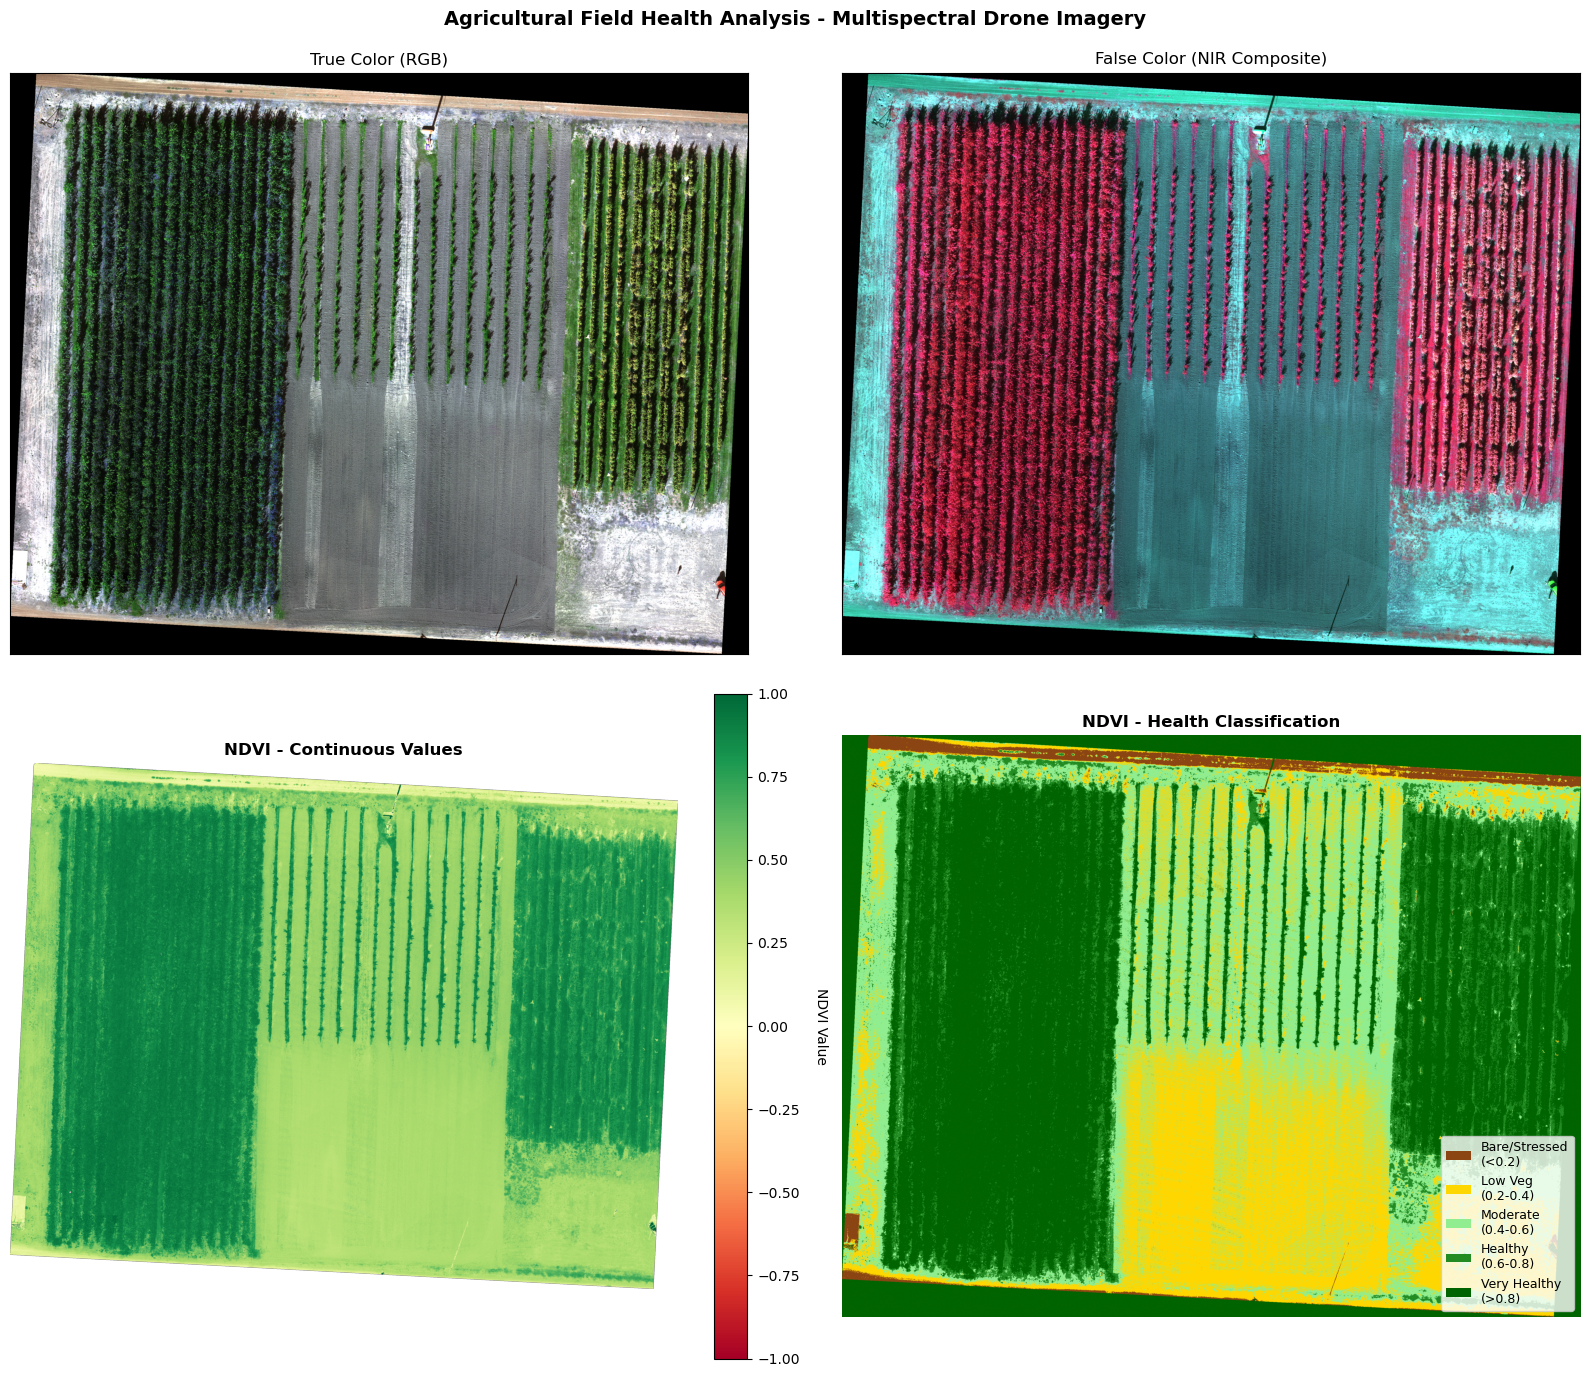


✓ 4-panel comparison complete!


In [7]:
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)
print("\n[1/3] Creating 4-panel comparison figure...")

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))  # 16 inches wide, 14 inches tall
# axes is a 2D array: axes[row, column]

# ----- Panel 1: True Color RGB -----
# ep.plot_rgb displays a 3-band image as RGB
ep.plot_rgb(
    ortho_arr,           # Our multispectral data
    ax=axes[0, 0],       # Plot in top-left subplot
    rgb=[0, 1, 2],       # Use bands 0(R), 1(G), 2(B)
    title="True Color (RGB)",
    stretch=True         # Enhance contrast for better visualization
)

# ----- Panel 2: False Color (NIR Composite) -----
# False color shows NIR as red - vegetation appears red/pink
ep.plot_rgb(
    ortho_arr,
    ax=axes[0, 1],       # Plot in top-right subplot
    rgb=[3, 0, 1],       # Use bands 3(NIR)→R, 0(Red)→G, 1(Green)→B
    title="False Color (NIR Composite)",
    stretch=True
)

# ----- Panel 3: NDVI Continuous -----
# Show NDVI as continuous values with color scale
ndvi_plot = axes[1, 0].imshow(
    ndvi,                # Our NDVI array
    cmap='RdYlGn',       # Color map: Red-Yellow-Green
    vmin=-1,             # Minimum NDVI value
    vmax=1               # Maximum NDVI value
)
axes[1, 0].set_title('NDVI - Continuous Values', fontweight='bold', fontsize=12)
axes[1, 0].axis('off')  # Hide axis numbers

# Add colorbar (legend) for NDVI values
cbar1 = plt.colorbar(ndvi_plot, ax=axes[1, 0], fraction=0.046)  # fraction controls size
cbar1.set_label('NDVI Value', rotation=270, labelpad=20)  # Label on right side

# ----- Panel 4: NDVI Classified -----
# Show NDVI as discrete health categories
from matplotlib.colors import ListedColormap

# Define colors for each class (brown→yellow→light green→green→dark green)
class_colors = ['#8B4513', '#FFD700', '#90EE90', '#228B22', '#006400']
cmap_classified = ListedColormap(class_colors)  # Create custom colormap

classified_plot = axes[1, 1].imshow(
    ndvi_classes,        # Our classified array (1-5)
    cmap=cmap_classified,
    vmin=1,              # Class 1 = first color
    vmax=5               # Class 5 = last color
)
axes[1, 1].set_title('NDVI - Health Classification', fontweight='bold', fontsize=12)
axes[1, 1].axis('off')

# Add legend showing what each color means
from matplotlib.patches import Patch
class_names = [
    'Bare/Stressed\n(<0.2)',
    'Low Veg\n(0.2-0.4)',
    'Moderate\n(0.4-0.6)',
    'Healthy\n(0.6-0.8)',
    'Very Healthy\n(>0.8)'
]
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) 
                   for i in range(len(class_names))]
axes[1, 1].legend(handles=legend_elements, loc='lower right', fontsize=9)

# Add overall title
plt.suptitle('Agricultural Field Health Analysis - Multispectral Drone Imagery',
             fontsize=14, fontweight='bold', y=0.98)

# Adjust spacing between subplots
plt.tight_layout()

# Save to file
output_file = 'output/ndvi_4panel_comparison.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_file}")

# Display in notebook
plt.show()

print("\n✓ 4-panel comparison complete!")

## 8. Visualization 2: Clean Presentation Map

This creates a single, clean NDVI map perfect for:
- PowerPoint presentations
- Reports for non-technical audiences
- Client deliverables

Features:
- Large, easy-to-read NDVI map
- Interpretation guide built into the image
- Field statistics displayed
- Clean, professional appearance


[2/3] Creating clean presentation map...
✓ Saved: output/ndvi_presentation_clean.png


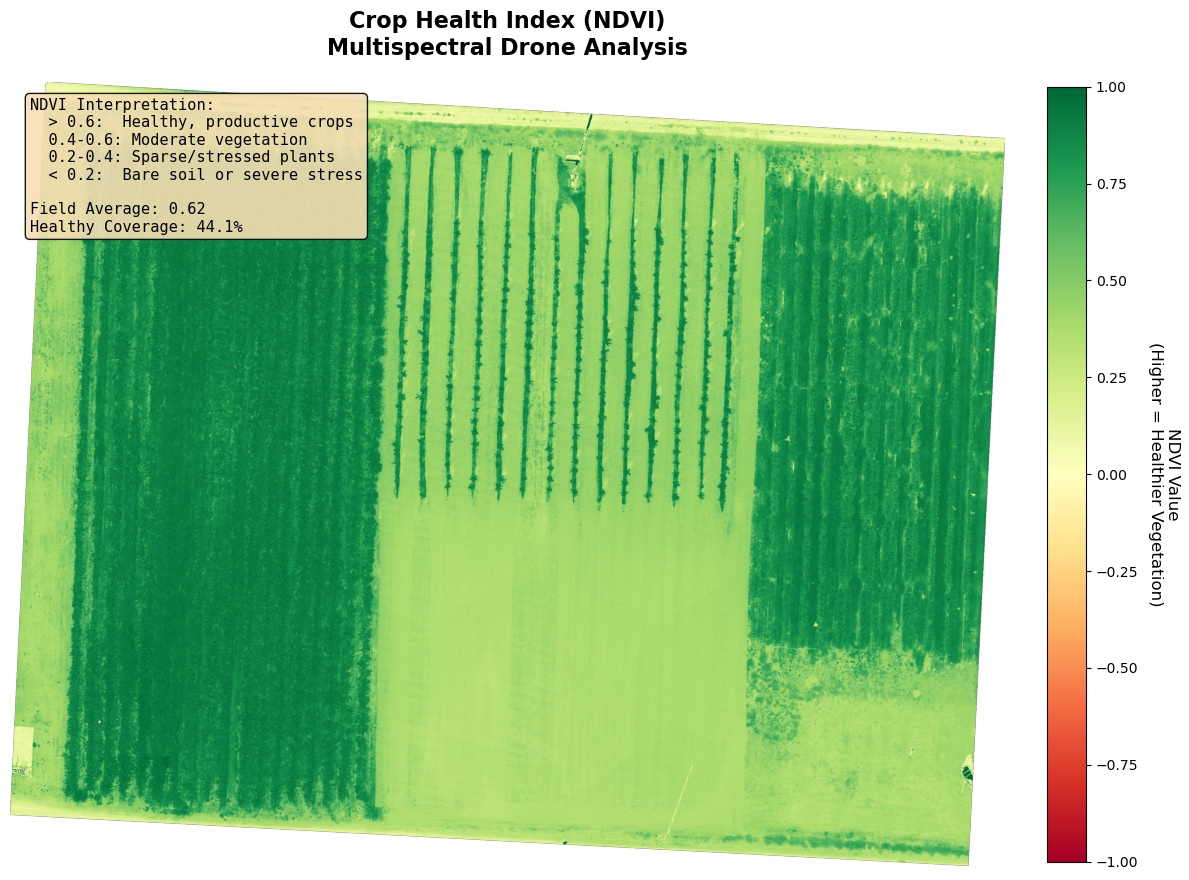


✓ Presentation map complete!


In [8]:
print("\n[2/3] Creating clean presentation map...")

# Create figure (single large plot)
fig, ax = plt.subplots(figsize=(12, 10))  # 12 inches wide, 10 inches tall

# Display NDVI with color scale
ndvi_display = ax.imshow(
    ndvi,
    cmap='RdYlGn',       # Red = low, Yellow = medium, Green = high
    vmin=-1,
    vmax=1
)

# Title
ax.set_title(
    'Crop Health Index (NDVI)\nMultispectral Drone Analysis',
    fontsize=16,
    fontweight='bold',
    pad=20  # Space between title and image
)
ax.axis('off')  # Hide axes

# Add colorbar
cbar = plt.colorbar(ndvi_display, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label(
    'NDVI Value\n(Higher = Healthier Vegetation)',
    fontsize=12,
    rotation=270,        # Rotate label vertically
    labelpad=30          # Space from colorbar
)

# Add interpretation text box
# This helps non-technical viewers understand the map
textstr = '\n'.join([
    'NDVI Interpretation:',
    '  > 0.6:  Healthy, productive crops',
    '  0.4-0.6: Moderate vegetation',
    '  0.2-0.4: Sparse/stressed plants',
    '  < 0.2:  Bare soil or severe stress',
    '',
    f'Field Average: {ndvi_mean:.2f}',
    f'Healthy Coverage: {(healthy_veg + very_healthy):.1f}%'
])

# Create a box with rounded corners and beige background
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)  # alpha = transparency

# Place text in top-left corner
ax.text(
    0.02, 0.98,          # Position (x, y) in axes coordinates (0-1)
    textstr,
    transform=ax.transAxes,  # Use axes coordinates, not data coordinates
    fontsize=11,
    verticalalignment='top',  # Align to top
    bbox=props,
    family='monospace'        # Fixed-width font for alignment
)

# Adjust layout
plt.tight_layout()

# Save to file
output_file = 'output/ndvi_presentation_clean.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_file}")

# Display in notebook
plt.show()

print("\n✓ Presentation map complete!")

## 9. Visualization 3: Statistics Dashboard

This creates a 4-panel dashboard with detailed statistics:
1. **Histogram**: Distribution of NDVI values across the field
2. **Pie chart**: Percentage breakdown by health category
3. **Profile**: NDVI values along a transect across the field
4. **Summary table**: Key statistics

This is useful for detailed analysis and reporting.


[3/3] Creating statistics dashboard...
✓ Saved: output/ndvi_statistics_dashboard.png


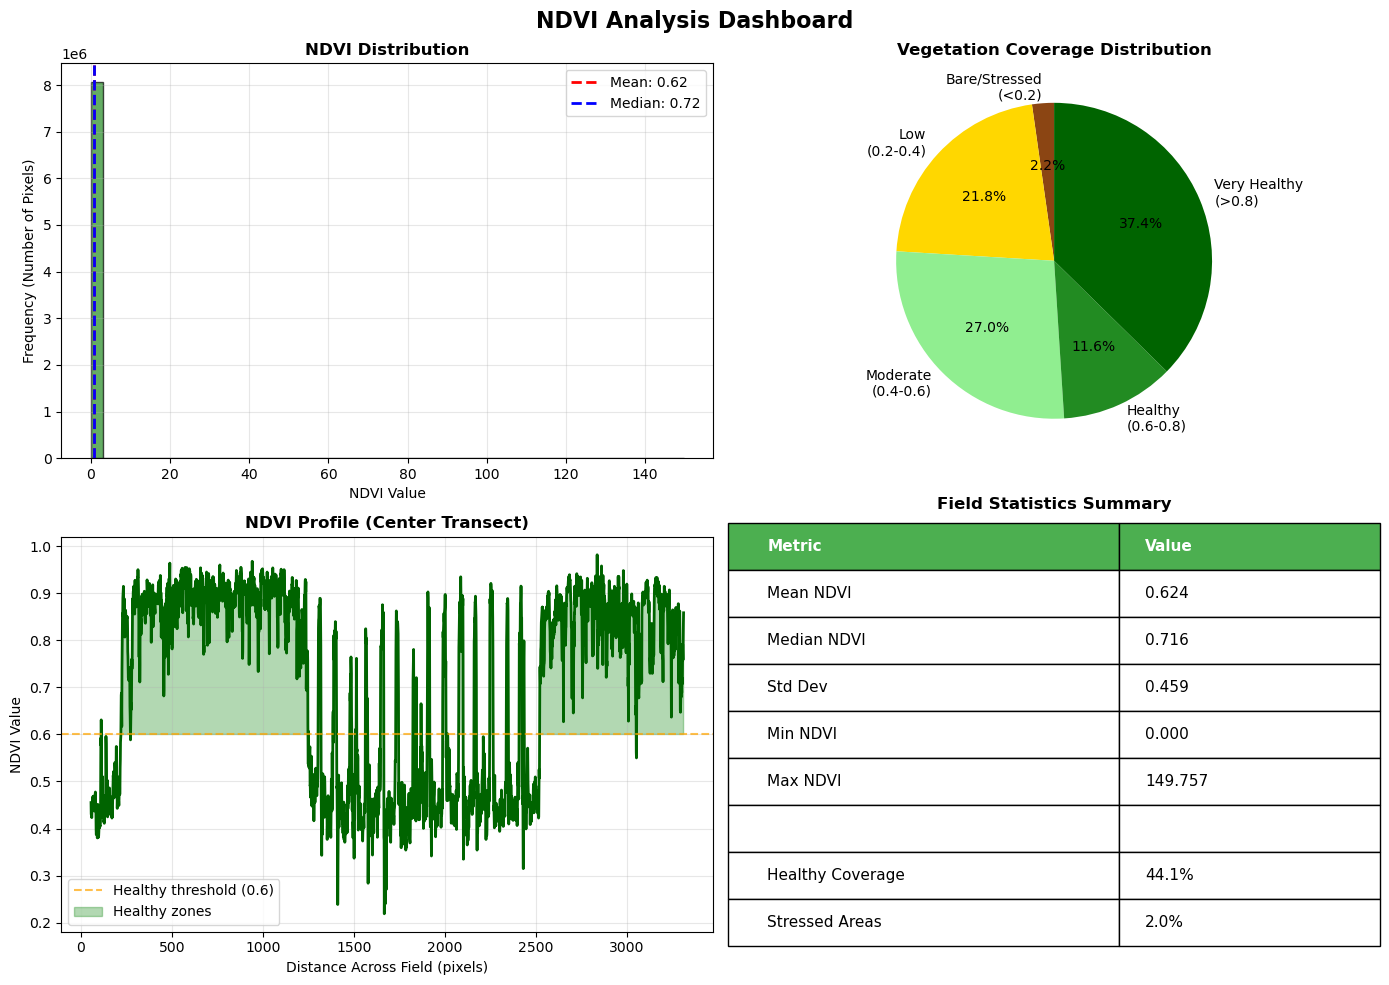


✓ Statistics dashboard complete!


In [9]:
print("\n[3/3] Creating statistics dashboard...")

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ----- Plot 1: Histogram of NDVI values -----
# Shows how NDVI values are distributed
axes[0, 0].hist(
    ndvi[~np.isnan(ndvi)].flatten(),  # Flatten to 1D array, remove NaN values
    bins=50,                          # Number of bars in histogram
    color='forestgreen',
    alpha=0.7,                        # Transparency
    edgecolor='black'
)

# Add vertical lines showing mean and median
axes[0, 0].axvline(ndvi_mean, color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {ndvi_mean:.2f}')
axes[0, 0].axvline(ndvi_median, color='blue', linestyle='--',
                   linewidth=2, label=f'Median: {ndvi_median:.2f}')

axes[0, 0].set_xlabel('NDVI Value')
axes[0, 0].set_ylabel('Frequency (Number of Pixels)')
axes[0, 0].set_title('NDVI Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)  # Light grid lines

# ----- Plot 2: Pie chart of vegetation coverage -----
coverage_data = [bare_soil, low_veg, moderate_veg, healthy_veg, very_healthy]
coverage_labels = [
    'Bare/Stressed\n(<0.2)',
    'Low\n(0.2-0.4)',
    'Moderate\n(0.4-0.6)',
    'Healthy\n(0.6-0.8)',
    'Very Healthy\n(>0.8)'
]

axes[0, 1].pie(
    coverage_data,
    labels=coverage_labels,
    autopct='%1.1f%%',    # Show percentages on pie slices
    colors=class_colors,   # Use same colors as classification map
    startangle=90          # Start first slice at top
)
axes[0, 1].set_title('Vegetation Coverage Distribution', fontweight='bold')

# ----- Plot 3: NDVI Profile (transect across field) -----
# Take a slice through the middle of the field
center_row = ndvi.shape[0] // 2  # // is integer division (gives whole number)
profile = ndvi[center_row, :]     # Get all columns from the center row

axes[1, 0].plot(profile, color='darkgreen', linewidth=2)

# Add reference line at healthy threshold
axes[1, 0].axhline(0.6, color='orange', linestyle='--',
                   alpha=0.7, label='Healthy threshold (0.6)')

# Highlight areas above threshold with green shading
axes[1, 0].fill_between(
    range(len(profile)),  # x values (pixel positions)
    profile,              # y values (NDVI)
    0.6,                  # Fill from NDVI value to 0.6
    where=(profile >= 0.6),  # Only where NDVI >= 0.6
    color='green',
    alpha=0.3,
    label='Healthy zones'
)

axes[1, 0].set_xlabel('Distance Across Field (pixels)')
axes[1, 0].set_ylabel('NDVI Value')
axes[1, 0].set_title('NDVI Profile (Center Transect)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# ----- Plot 4: Summary statistics table -----
# Create a table with key statistics
stats_data = [
    ['Metric', 'Value'],                           # Header row
    ['Mean NDVI', f'{ndvi_mean:.3f}'],
    ['Median NDVI', f'{ndvi_median:.3f}'],
    ['Std Dev', f'{ndvi_std:.3f}'],
    ['Min NDVI', f'{ndvi_min:.3f}'],
    ['Max NDVI', f'{ndvi_max:.3f}'],
    ['', ''],                                      # Blank row
    ['Healthy Coverage', f'{(healthy_veg + very_healthy):.1f}%'],
    ['Stressed Areas', f'{bare_soil:.1f}%'],
]

axes[1, 1].axis('off')  # Hide axes for table

# Create table
table = axes[1, 1].table(
    cellText=stats_data,
    cellLoc='left',           # Left-align text
    loc='center',             # Center table in plot area
    colWidths=[0.6, 0.4]      # Column width ratios
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)  # Make cells taller

# Color the header row green
for i in range(2):  # For each column
    table[(0, i)].set_facecolor('#4CAF50')  # Green background
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Field Statistics Summary', fontweight='bold', pad=20)

# Overall title
plt.suptitle('NDVI Analysis Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save to file
output_file = 'output/ndvi_statistics_dashboard.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_file}")

# Display in notebook
plt.show()

print("\n✓ Statistics dashboard complete!")

## 10. Export Summary Report

This cell creates a text summary of the analysis that can be:
- Copied into reports
- Saved as a separate file
- Shared with stakeholders

It includes key findings and interpretation for non-technical audiences.

In [10]:
print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

# List output files
print("\n📁 OUTPUT FILES (in 'output/' folder):")
print("-" * 60)
output_files = [
    ('ndvi_4panel_comparison.png', 'Comprehensive 4-panel analysis'),
    ('ndvi_presentation_clean.png', 'Clean map for presentations'),
    ('ndvi_statistics_dashboard.png', 'Statistical summary dashboard')
]

for filename, description in output_files:
    filepath = f'output/{filename}'
    if os.path.exists(filepath):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"✓ {filename}")
        print(f"  {description} ({size_kb:.1f} KB)")
    else:
        print(f"✗ {filename} - Not created")

# Key findings summary
print("\n" + "="*60)
print("📊 KEY FINDINGS:")
print("="*60)
print(f"Field Average NDVI:        {ndvi_mean:.3f}")
print(f"Healthy Vegetation (>0.6): {(healthy_veg + very_healthy):.1f}%")
print(f"Moderate Vegetation:       {moderate_veg:.1f}%")
print(f"Stressed/Bare Areas (<0.2): {bare_soil:.1f}%")

# Recommendations
print("\n" + "="*60)
print("💡 RECOMMENDATIONS:")
print("="*60)

healthy_total = healthy_veg + very_healthy

if healthy_total > 70:
    print("✓ Field shows excellent vegetation health")
    print("  → Continue current management practices")
    print("  → Monitor for early signs of stress in low-NDVI areas")
elif healthy_total > 50:
    print("✓ Field shows good overall health with room for improvement")
    print("  → Target moderate NDVI areas for irrigation/nutrient optimization")
    print("  → Investigate spatial patterns for management zones")
else:
    print("⚠️  Field shows concerning vegetation stress")
    print("  → Investigate causes: water stress, nutrients, pests, disease")
    print("  → Consider soil sampling in low-NDVI zones")
    print("  → Review irrigation system performance")

if bare_soil > 20:
    print("\n⚠️  Significant bare/stressed areas detected")
    print("  → These areas may indicate:")
    print("    • Drought stress or irrigation issues")
    print("    • Nutrient deficiency (nitrogen, phosphorus)")
    print("    • Disease or pest damage")
    print("    • Soil quality problems")
    print("  → Recommended: Field inspection + targeted intervention")

# Application to water quality projects
print("\n" + "="*60)
print("🌊 APPLICATION TO WATER QUALITY MANAGEMENT:")
print("="*60)
print("This NDVI analysis supports:")
print("")
print("1. PRECISION IRRIGATION:")
print("   → Identify zones needing irrigation adjustments")
print("   → Optimize water use efficiency")
print("   → Reduce water waste and nitrate leaching")
print("")
print("2. NITROGEN MANAGEMENT (Ag Order 4.0 Compliance):")
print("   → Document effective nitrogen uptake (healthy NDVI = good N use)")
print("   → Support Irrigation & Nutrient Management Plan (INMP)")
print("   → Show vegetation response to fertilizer applications")
print("")
print("3. BIOREACTOR/TREATMENT SYSTEM VALIDATION:")
print("   → Compare crop health before/after treated water use")
print("   → Demonstrate ROI from water quality improvements")
print("   → Quantify vegetation coverage increases over time")
print("")
print("4. TEMPORAL MONITORING:")
print("   → Repeat this analysis monthly/seasonally")
print("   → Track crop health trends over growing season")
print("   → Correlate NDVI changes with water quality interventions")

# Next steps
print("\n" + "="*60)
print("🚀 NEXT STEPS:")
print("="*60)
print("1. Review the three PNG images in the 'output' folder")
print("2. Use 'ndvi_presentation_clean.png' in PowerPoint/reports")
print("3. For time-series analysis:")
print("   → Collect imagery from multiple dates (monthly/seasonal)")
print("   → Re-run this notebook for each date")
print("   → Compare NDVI statistics over time")
print("4. For detailed zone analysis:")
print("   → Create field boundary shapefiles")
print("   → Calculate NDVI statistics per management zone")
print("   → Support precision agriculture decisions")

print("\n" + "="*60)
print("✓ Analysis complete! Check the 'output' folder for results.")
print("="*60)


ANALYSIS COMPLETE!

📁 OUTPUT FILES (in 'output/' folder):
------------------------------------------------------------
✓ ndvi_4panel_comparison.png
  Comprehensive 4-panel analysis (28111.3 KB)
✓ ndvi_presentation_clean.png
  Clean map for presentations (9941.2 KB)
✓ ndvi_statistics_dashboard.png
  Statistical summary dashboard (601.4 KB)

📊 KEY FINDINGS:
Field Average NDVI:        0.624
Healthy Vegetation (>0.6): 44.1%
Moderate Vegetation:       24.3%
Stressed/Bare Areas (<0.2): 2.0%

💡 RECOMMENDATIONS:
⚠️  Field shows concerning vegetation stress
  → Investigate causes: water stress, nutrients, pests, disease
  → Consider soil sampling in low-NDVI zones
  → Review irrigation system performance

🌊 APPLICATION TO WATER QUALITY MANAGEMENT:
This NDVI analysis supports:

1. PRECISION IRRIGATION:
   → Identify zones needing irrigation adjustments
   → Optimize water use efficiency
   → Reduce water waste and nitrate leaching

2. NITROGEN MANAGEMENT (Ag Order 4.0 Compliance):
   → Document

---

## Optional: Save Results as CSV

If you want to export the statistics to a CSV file for use in Excel or other programs, run this cell.

In [11]:
# Optional: Export statistics to CSV
import csv

# Prepare data for export
export_data = [
    ['Metric', 'Value'],
    ['Analysis Date', '2026-02-05'],  # Update with actual date
    ['Data Source', 'DroneMapper Multispectral Imagery'],
    ['Sensor', 'MicaSense Altum'],
    ['', ''],
    ['NDVI Statistics', ''],
    ['Mean NDVI', f'{ndvi_mean:.4f}'],
    ['Median NDVI', f'{ndvi_median:.4f}'],
    ['Std Deviation', f'{ndvi_std:.4f}'],
    ['Minimum NDVI', f'{ndvi_min:.4f}'],
    ['Maximum NDVI', f'{ndvi_max:.4f}'],
    ['', ''],
    ['Vegetation Coverage', 'Percentage'],
    ['Bare/Stressed (<0.2)', f'{bare_soil:.2f}%'],
    ['Low Vegetation (0.2-0.4)', f'{low_veg:.2f}%'],
    ['Moderate Vegetation (0.4-0.6)', f'{moderate_veg:.2f}%'],
    ['Healthy Vegetation (0.6-0.8)', f'{healthy_veg:.2f}%'],
    ['Very Healthy (>0.8)', f'{very_healthy:.2f}%'],
    ['', ''],
    ['Total Healthy Coverage (>0.6)', f'{(healthy_veg + very_healthy):.2f}%'],
]

# Write to CSV
output_csv = 'output/ndvi_statistics.csv'
with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(export_data)

print(f"✓ Statistics exported to: {output_csv}")
print("  You can open this file in Excel or any spreadsheet program")

✓ Statistics exported to: output/ndvi_statistics.csv
  You can open this file in Excel or any spreadsheet program


---

## Notebook Complete!

### What You've Accomplished:
✅ Loaded high-resolution multispectral drone imagery  
✅ Calculated NDVI vegetation health index  
✅ Classified vegetation into health categories  
✅ Created 3 professional visualizations  
✅ Exported presentation-ready images  


---

**Questions or need to modify the analysis?**
- Change NDVI thresholds: Edit the `bins` variable in Cell 6
- Adjust color schemes: Modify `class_colors` or `cmap` parameters
- Add more statistics: Use numpy functions on the `ndvi` array
- Create custom plots: Use matplotlib syntax in new cells

## Next Steps for Avocado Chloride Project

This notebook analyzes NDVI over a whole field using example data.  
To support the Cam Lam Farms chloride‑removal trial, the next steps are:

1. Acquire weekly multispectral drone imagery (DJI P4 multispectral or similar) over the control and treatment avocado rows using a consistent flight plan.
2. Generate georeferenced per‑band orthomosaics (Red, NIR, etc.) for each week.
3. Create polygons for the control and treatment plots (or individual trees), then compute NDVI statistics per plot/tree and week using those boundaries.
4. Combine NDVI with water‑quality and irrigation data (flow, treated Cl, week, Eto, Ec) into a single analysis table.
5. Fit regression or mixed‑effects models to test for differences in NDVI over time between control and treatment trees, and visualize NDVI trends (plots and time‑lapse maps) for technical reports and grower outreach.

### Georeferencing & Clipping for New Drone Data

For the Cam Lam Farms trial we will assume that the DJI P4 Multispectral workflow
(typically via DJI Terra or similar software) produces georeferenced orthomosaic
GeoTIFFs for each weekly flight. In that case, the images already contain all
spatial reference information, and Python does **not** need to perform
photogrammetry or georeferencing from scratch.

To adapt this notebook for the new data we would:

1. Use the same NDVI workflow on the DJI‑generated GeoTIFFs.
2. Define polygons for control and treatment rows (or individual trees) in a GIS
   tool and save them as a shapefile or GeoJSON.
3. Use `geopandas` + `rasterio.mask` + `rasterstats` to clip NDVI to those
   polygons and compute per‑plot or per‑tree NDVI statistics.

If, in the future, raw non‑georeferenced images are used, full photogrammetry
would be handled by dedicated software (e.g., DJI Terra, Pix4D, Agisoft), and
the notebook would still operate on their georeferenced GeoTIFF outputs.
